# 2D Bloch-Schrödinger versus tight-binding: package compatibility

Computing the band structure of a periodic lattice using a fully 2D solver such as the one presented here is much more quantitatively accurate than a tightbinding approach, but also much slower. Here, we compare the two approaches using the 'tightbinding' module. You can find it [here](https://github.com/GuillotMartin/tightbinding) and install it before going on with this notebook.

## Building the lattice

Our goal is to compare the band structure of the honeycomb lattice obtained first by a 2D Bloch-Schrödinger approach and then by a tightbinding model. Let's first proceed with the first method.

100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


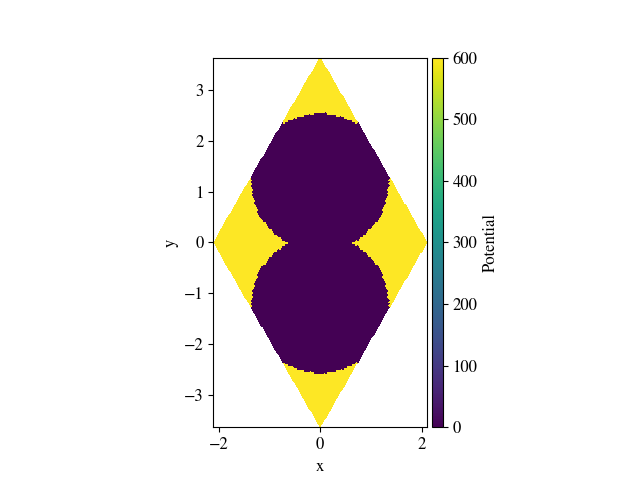

In [6]:
from bloch_schrodinger.potential import honeycomb
from bloch_schrodinger.solver import Solver

import numpy as np
import xarray as xr

a = 2.4
r = 1.35

honey = honeycomb(a = 2.4, rA = r, rB = r, v0 = 600)

%matplotlib widget
honey.plot()

kl = 1.6
nk = 100
honey_solv = Solver(honey, 1)
honey_solv.create_reciprocal_grid(kx = np.linspace(-kl,kl, nk))
eigva_2d, eigve_2d = honey_solv.solve(n_eigva=6) # we solve for the s and p bands

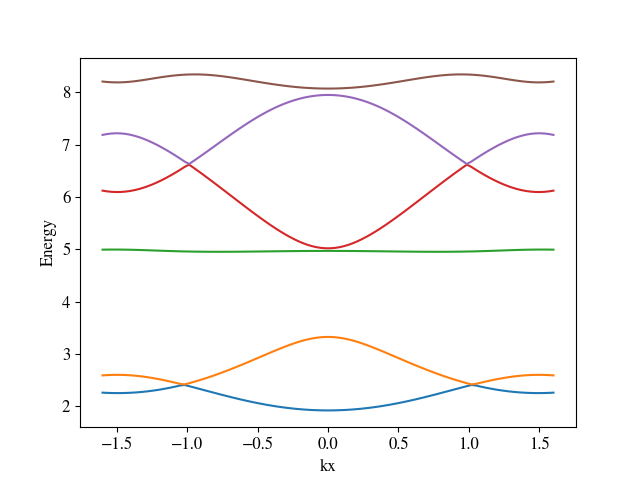

In [7]:
import bloch_schrodinger.plotting as bl_plt 

bl_plt.plot_bands(eigva_2d, dim = 'kx')

We now have to build the Hamitlonian using a tight-binding approach, to do so, we use the tightbinding package. The process is longer, as each parameter must be specified by hand, instead of deriving from the potential geometry. We first set the parameters to match approximately the band structure, while leaving some as parameters dimensions to ajust finely.

In [8]:
from tightbinding.geometry import Orbital, Site, Unitcell, Lattice

s = Orbital('s')
px = Orbital('px')
py = Orbital('py')

a_site = Site('A', [0, a/2], [s, px, py])
b_site = Site('B', [0, -a/2], [s, px, py])

a1 = [-3**0.5/2 * a, 3/2 * a] # 1st lattice vector
a2 = [3**0.5/2 * a, 3/2 * a] # 2nd lattice vector
uc = Unitcell("honeycomb", [a1,a2])
uc.add_site([a_site,b_site])

# Creating a periodic lattice made of a single unit cell
honeycomb = Lattice('honeycomb', uc, (True, True))
honeycomb.add_unitcell((0,0), update=True)

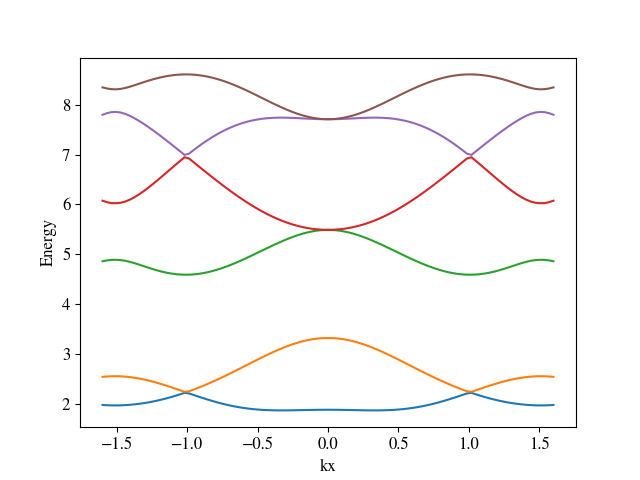

In [34]:
from tightbinding.hamiltonian import Energy, Hopping, Hamiltonianbuilder
import numpy as np

nk = 100 # I recommand an even number of points for k-space sampling, so as not to get high-symmetry points at the vertices of the grid.

parameters = {
    "kx": np.linspace(-kl, kl, nk),
    "ky": 0,
    "es": 2.6, # The energy of the s mode
    "ep": 6.6, # the energy of the p modes
    "ts": -0.24, # hopping strength between s-orbitals
    "tsp": np.linspace(-0.1, -0.6, 50), # s-p hopping strength
    "tl": 1.04, # p-orbital longitudinal hopping strength
    "tt": np.linspace(-0.3, 0, 50), # p-orbital transversal hopping strength
}

onsite = Energy(honeycomb)
onsite.set_energy("es", norbital='s') # s-orbital energy
onsite.set_energy("ep", norbital="px") # p orbitals energy
onsite.set_energy("ep", norbital="py") # p orbitals energy

links = [(0,0), (1,0), (0,1)]
links_angle = [-np.pi/2 + 2*np.pi/3*k for k in range(3)] # The links direction, important to compute the hopping strength between p orbitals
link_ortho = [theta + np.pi/2 for theta in links_angle] # the orthogonal to the link direction


couplings = [Hopping(honeycomb, f"ts", "A_s", "B_s", link) for link in links] # s-s coupling

couplings += [Hopping(honeycomb, f"np.cos({angle}) * np.cos({angle}) * tl", "A_px", "B_px", link) for angle, link in zip(links_angle, links)] # px-px longitudinal hoppings
couplings += [Hopping(honeycomb, f"np.cos({angle}) * np.sin({angle}) * tl", "A_px", "B_py", link) for angle, link in zip(links_angle, links)] # px-py longitudinal hoppings
couplings += [Hopping(honeycomb, f"np.sin({angle}) * np.cos({angle}) * tl", "A_py", "B_px", link) for angle, link in zip(links_angle, links)] # py-px longitudinal hoppings
couplings += [Hopping(honeycomb, f"np.sin({angle}) * np.sin({angle}) * tl", "A_py", "B_py", link) for angle, link in zip(links_angle, links)] # py-py longitudinal hoppings

couplings += [Hopping(honeycomb, f"np.cos({angle}) * np.cos({angle}) * tt", "A_px", "B_px", link) for angle, link in zip(link_ortho, links)] # px-px transverse hoppings
couplings += [Hopping(honeycomb, f"np.cos({angle}) * np.sin({angle}) * tt", "A_px", "B_py", link) for angle, link in zip(link_ortho, links)] # px-py transverse hoppings
couplings += [Hopping(honeycomb, f"np.sin({angle}) * np.cos({angle}) * tt", "A_py", "B_px", link) for angle, link in zip(link_ortho, links)] # py-px transverse hoppings
couplings += [Hopping(honeycomb, f"np.sin({angle}) * np.sin({angle}) * tt", "A_py", "B_py", link) for angle, link in zip(link_ortho, links)] # py-py transverse hoppings

couplings += [Hopping(honeycomb, f"np.cos({angle}) * tsp", "A_s", "B_px", link) for angle, link in zip(links_angle, links)] # s-px hoppings
couplings += [Hopping(honeycomb, f"np.sin({angle}) * tsp", "A_s", "B_py", link) for angle, link in zip(links_angle, links)] # s-py hoppings
couplings += [Hopping(honeycomb, f"np.cos({angle}) * tsp", "A_px", "B_s", link) for angle, link in zip(links_angle, links)] # px-s hoppings
couplings += [Hopping(honeycomb, f"np.sin({angle}) * tsp", "A_py", "B_s", link) for angle, link in zip(links_angle, links)] # py-s hoppings


H = Hamiltonianbuilder(honeycomb, parameters, reciprocalcoords=["kx", "ky"])
H.set_on_site_energies(onsite)
H.add_couplings(couplings)
H.build()
eigva_tb, eigve_tb = H.eigh() # solving the eigenproblem, even for 250 x 100 hamiltonian is extremely fast

bl_plt.plot_bands(eigva_tb, 'kx') # The eigenvalue DataArrays coming from both packages have the same shape

Now that we have both band structure, it is very easy to compare them:

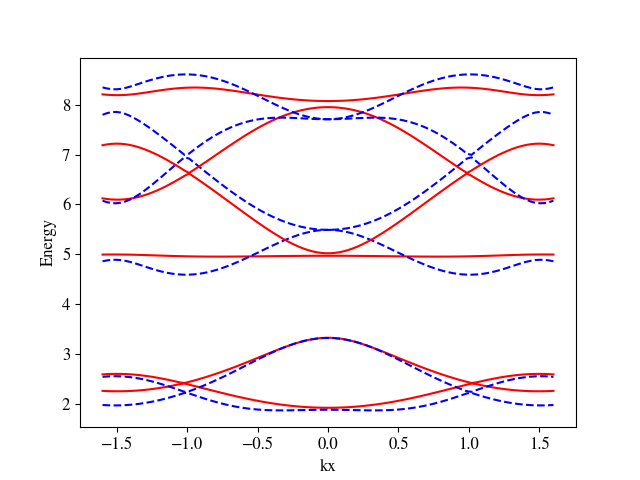

In [35]:
# We need to combine both arrays
# first, we reindex the bands to avoid indexing conflicts

eigva_2d.coords['band'] = 2*np.arange(6)
eigva_tb.coords['band'] = 2*np.arange(6)+1

eigva = xr.concat([eigva_2d, eigva_tb], dim = 'band').sortby('band') # Using the concat method, we combine the bands structure.

template_tb = {"color":"blue", "linestyle":'dashed'}
template_2d = {"color":"red"}

bl_plt.plot_bands(eigva, 'kx', linekws = [template_2d, template_tb]) # we specify the templates for each lines, to distinguish between 2d bands and tightbinding bands


We can find a very good argreement between the two dispersions for $t_{sp} = -0.4$ and $t_t = -0.1$. Of course, some slight differences persists, but this small example demonstrate the usefulness of the tight binding approach, as well as the inter-operability of the two packages. 